<a href="https://colab.research.google.com/github/laagrrluv/free_improv_AI_buddy/blob/main/AI_trigger2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal ot this project is to create an instrument for free improvisational music.

ML definition - 

First iteration - Trigger

Create some kind of beat using sequenced samples
training data generation by playing along to the beat (human following machine)
Train ML-model using human-played audio as input (X) and machine audio as output (y)
Let ML-prediction trigger samples from free improvised human-played audio (machine following human)


Real-Time application
Correct triggers




WOrkflow

Create some kind of event based music (drum machine, midi notes, sequenced effects...)

Play along with an analog instrument (guitar, bass, vocals...)

Train ML-model using analog instrument as input (X) and events as output (y)

What happens when running new analog audio through the ML-model?

Playing the same riff as in the training data, will it trigger the correct events?

More interestingly, if a new riff is played, will it trigger events that "makes sense"?


THis is a first prototype, I'm taking two major short cuts to test the concept.

Not performed in real time. This concept doesn't really make sense when it's not possible to "Jam with the AI" in real time. Got plans involving raspberry pi and Elk Audio. 

The event-times are pre-determined, even for the test set when playing new riffs. A good event trigger algorithm needs to be developed, with or without ML.



----


1. Human following machine. Playing bass along a drum machine.
2. Machine following human. The drums is generated by an AI using the bass audio as input. It sounds similar to #1 because the bass is playing the same bass line, but it's a nice validation of the AI because it's not the same audio as the AI was trained on.

3. to 5. Machine following human playing new bass lines. This is the main proof of concept. 
  1. The AI generated drums are consequent, playing a specific bass line generates a specific drum beat (more or less)
  2. The AI generated drums makes sense musically, but with a artificial weirdness that will be useful when using this system 

Github

ladda ljud




def sound (filename, bpm, beat)

out numpy, 

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
import librosa
import numpy as np
from IPython.display import Audio
import tensorflow as tf

In [ ]:












  #y=y-1
  



In [ ]:

#Audio(url='/content/gdrive/MyDrive/tracks2/drums.wav')

In [ ]:
import os
dir='/content/gdrive/MyDrive/tracks2/'
a_train, sr = librosa.load(dir+'bass_train.wav')

Audio(a_train[:200000],rate=sr)

In [ ]:
def get_beats(y,loop,bpm,sr):

  beats=np.zeros(len(y))
  #loop=[1,0,3,1,2,4,0,0,0,0,0,1,2,0,0,0,1,0,3,1,2,4,1,0,0,0,0,1,2,1,3,0]

  blen=int(60/bpm/4*sr) #nr of samples in a beat

  pos=[]

  for i in range(len(y)//blen):

    p=i*blen
    s=loop[i%len(loop)]

    beats[p]=s
    pos.append([p,s])
    
  return beats, np.array(pos)

rhythm=[1,0,3,1,2,4,0,0,0,0,0,1,2,0,0,0,1,0,3,1,2,4,1,0,0,0,0,1,2,1,3,0]

b,pos=get_beats(a_train,rhythm,96,sr)

pos.shape

(1056, 2)

In [ ]:
d,sr=librosa.load(dir+'drums.wav')

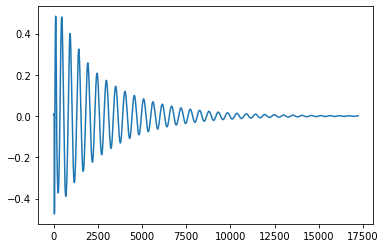

In [ ]:
#ersätt med samplingar!


import matplotlib.pyplot as plt

#plt.plot(plot[100000:200000])
#plt.plot(y[:100000])
#plt.plot(beat[:100000])

blen=int(60/96/4*sr)

samples=np.zeros((5,blen*5))
i=22
l=5
s=1
samples[s,:blen*l]=d[i*blen:(i+l)*blen]
i=4
l=1
s=2
samples[s,:blen*l]=d[i*blen:(i+l)*blen]
i=30
l=2
s=3
samples[s,:blen*l]=d[i*blen:(i+l)*blen]
i=5
l=5
s=4
samples[s,:blen*l]=d[i*blen:(i+l)*blen]

plt.plot(samples[1,:])

#plt.ylabel('some numbers')
#plt.show()

In [ ]:
def get_drum_audio(pos,samples):


  ls=samples.shape[1]
  a=np.zeros(pos[:,0].max()+ls)

  for p,s in pos:
    a[p:p+ls]=a[p:p+ls]+samples[s,:]
  
  return a

#listen to the drums
Audio(get_drum_audio(pos,samples)[:200000],rate=sr)

In [ ]:

#together with the bass

Audio(a_train[:200000]+get_drum_audio(pos,samples)[:200000],rate=sr)

In [ ]:
def normalize(X):
  mx=X.max(axis=0,keepdims=True).max(axis=1,keepdims=True)
  mn=X.min(axis=0,keepdims=True).min(axis=1,keepdims=True)
  X=(X-mn)/(mx-mn)
  return X


def fft(y):
  #buffer=512
  s=librosa.stft(y)#, n_fft=buffer, hop_length=buffer, win_length=buffer)
  s=s[:,:-1]  #remove last non-complete buffer to match beat_s
  s=abs(s)    
  s=s.T
  s=normalize(s)
  return s

###

s=fft(a_train)
s.shape


(7105, 1025)

In [ ]:
def beat_s(beat,buffer):

  beat=beat[:len(beat)//buffer*buffer] #remove last non-complete buffer so we can do reshape
  beat_s=beat.reshape(len(beat)//buffer,buffer).max(axis=1)
  return beat_s

###

buffer=512

bs=beat_s(b,buffer)
bs.shape

(7105,)

In [ ]:
def get_data(beat_s,s,X_len):
  y=[]
  X=[]
  for i in range(X_len,len(beat_s)):
    if beat_s[i]>0:
      y.append(beat_s[i])
      X.append(s[i-X_len:i,:])
  return np.array(X),np.array(y)

X,y = get_data(bs,s,sr//buffer//2)

y=y-1 #all datapoints are drum-events y>0, keras likes classes to start from 0

In [ ]:
n_channels=int(max(y)+1)
n_channels

4

In [ ]:
perm=np.concatenate((np.arange(64,128),np.arange(64),np.arange(64,X.shape[0]))) #test data is from somewhere in the middle of the sound

X_train=X[perm[64:],:,:]
y_train=y[perm[64:]]
X_test=X[perm[:64],:,:]
y_test=y[perm[:64]]

In [ ]:
inp=tf.keras.Input(shape=(X.shape[1],X.shape[2]))
conv1=tf.keras.layers.Conv1D(16,kernel_size=3)(inp)
conv2=tf.keras.layers.Conv1D(32,kernel_size=3)(conv1)
conv3=tf.keras.layers.Conv1D(64,kernel_size=3)(conv2)
flatten=tf.keras.layers.Flatten()(conv3)
dense=tf.keras.layers.Dense(n_channels, activation='softmax')(flatten)
model=tf.keras.Model(inp,dense)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21, 1025)]        0         
                                                                 
 conv1d (Conv1D)             (None, 19, 16)            49216     
                                                                 
 conv1d_1 (Conv1D)           (None, 17, 32)            1568      
                                                                 
 conv1d_2 (Conv1D)           (None, 15, 64)            6208      
                                                                 
 flatten (Flatten)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 4)                 3844      
                                                                 
Total params: 60,836
Trainable params: 60,836
Non-trainable p

In [ ]:
import sklearn
classes=np.unique(y)
class_weights = sklearn.utils.class_weight.compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(enumerate(class_weights)) 
class_weight_dict

{0: 0.5324427480916031,
 1: 1.0568181818181819,
 2: 1.4234693877551021,
 3: 2.1136363636363638}

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

model.fit(X_train,y_train,validation_data=[X_test,y_test],epochs=100,batch_size=X_train.shape[0],class_weight=class_weight_dict)

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 1.3974 - accuracy: 0.1111 - val_loss: 1.3788 - val_accuracy: 0.4219
Epoch 2/100
1/1 [==============================] - 0s 251ms/step - loss: 1.3690 - accuracy: 0.3889 - val_loss: 1.3567 - val_accuracy: 0.4688
Epoch 3/100
1/1 [==============================] - 0s 239ms/step - loss: 1.3415 - accuracy: 0.4982 - val_loss: 1.3337 - val_accuracy: 0.5625
Epoch 4/100
1/1 [==============================] - 0s 248ms/step - loss: 1.3117 - accuracy: 0.5394 - val_loss: 1.3082 - val_accuracy: 0.5781
Epoch 5/100
1/1 [==============================] - 0s 242ms/step - loss: 1.2778 - accuracy: 0.5556 - val_loss: 1.2791 - val_accuracy: 0.5938
Epoch 6/100
1/1 [==============================] - 0s 238ms/step - loss: 1.2385 - accuracy: 0.5842 - val_loss: 1.2457 - val_accuracy: 0.5938
Epoch 7/100
1/1 [==============================] - 0s 233ms/step - loss: 1.1937 - accuracy: 0.6111 - val_loss: 1.2080 - val_accuracy: 0.5938
Epoch 8/100
1/1 

In [ ]:
pred=model.predict(X_test)
pred.shape

(64, 4)

In [ ]:
pred.argmax(axis=1)
#pred[:,5].round(1)

array([2, 0, 2, 0, 1, 3, 0, 1, 0, 2, 0, 1, 3, 0, 0, 1, 0, 2, 0, 2, 0, 1,
       3, 0, 1, 0, 2, 0, 1, 3, 0, 0, 1, 0, 2, 0, 2, 0, 1, 3, 0, 1, 0, 2,
       0, 1, 3, 0, 0, 1, 0, 2, 0, 2, 0, 1, 3, 0, 1, 0, 2, 0, 1, 3])

In [ ]:
y_test.astype(int)

array([2, 0, 2, 0, 1, 3, 0, 1, 0, 2, 0, 1, 3, 0, 0, 1, 0, 2, 0, 2, 0, 1,
       3, 0, 1, 0, 2, 0, 1, 3, 0, 0, 1, 0, 2, 0, 2, 0, 1, 3, 0, 1, 0, 2,
       0, 1, 3, 0, 0, 1, 0, 2, 0, 2, 0, 1, 3, 0, 1, 0, 2, 0, 1, 3])

In [ ]:
test=[1,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,1,1,1,0,0,0,1,1,1,0,0,0,1,1,1,0] #1
#len(test1)
#test=[1,1,0,0,0,0,1,0,0,0,1,0,1,1,1,0,1,1,0,1,1,0,0,1,1,0,0,0,1,1,1,0] #2
#len(test2)
y, sr = librosa.load(dir+files[1])

In [ ]:
#comp=y[:70*blen]



#for i in range(64):
#  lb=test[i%32]


#  comp[i*blen:(i+5)*blen]=comp[i*blen:(i+5)*blen]+samples[lb,:]
  #comp[i*blen]=loop[i%32]

#Audio(comp,rate=sr)

In [ ]:
beat=np.zeros(len(y))
loop=test
blen=int(60/96/4*sr)

for i in range(len(y)//blen):
  beat[i*blen]=loop[i%32]

In [ ]:
#buffer=128

s=librosa.stft(y)#, n_fft=buffer, hop_length=buffer, win_length=buffer)
s=s[:,:-1]
s=abs(s)
s=s.T
s.shape

(3015, 1025)

In [ ]:
beat=beat[:len(beat)//buffer*buffer]
beat_s=beat.reshape(len(beat)//buffer,buffer).max(axis=1)
beat_s.shape

(3015,)

In [ ]:
X_len=sr//buffer//2

#y=[]
X=[]

for i in range(X_len,len(beat_s)):
  if beat_s[i]>0:
 #   y.append(beat_s[i])
    X.append(s[i-X_len:i,:])

X=np.array(X)
#y=np.array(y)

#y=y-1


print (X.shape)
#print (y.shape)
#print(y)


(207, 21, 1025)


In [ ]:
mx=X.max(axis=0,keepdims=True).max(axis=1,keepdims=True)
mn=X.min(axis=0,keepdims=True).min(axis=1,keepdims=True)

X=(X-mn)/(mx-mn)


In [ ]:
pred=model.predict(X)#*np.array((0.01,1,1,1))
#pred

In [ ]:
bt=(np.array(test)>0).sum()
lt=len(X)//bt
lt

13

In [ ]:
pa=pred.argmax(axis=1)
pa[0:bt*lt].reshape((lt,bt))

array([[0, 1, 0, 0, 1, 0, 0, 1, 2, 0, 1, 2, 0, 0, 0],
       [0, 1, 2, 0, 1, 0, 0, 1, 2, 0, 1, 2, 0, 0, 0],
       [0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 2, 0],
       [0, 1, 2, 0, 1, 0, 0, 1, 2, 0, 1, 2, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 1, 2, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 2, 0, 1, 2, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 2, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 2, 0, 1, 2, 0, 1, 0, 0, 0, 0],
       [0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 0, 0, 0, 0],
       [0, 1, 2, 0, 1, 0, 0, 1, 2, 0, 1, 0, 0, 0, 0],
       [0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 0, 0, 0, 0],
       [0, 1, 2, 0, 1, 0, 0, 1, 2, 0, 1, 0, 0, 0, 0]])

In [ ]:
beats=np.where(beat>0)[0][-len(pa):]
beats

array([  20670,   24115,   27560,   55120,   58565,   62010,   75790,
         79235,   82680,   96460,   99905,  103350,  110240,  113685,
        117130,  130910,  134355,  137800,  165360,  168805,  172250,
        186030,  189475,  192920,  206700,  210145,  213590,  220480,
        223925,  227370,  241150,  244595,  248040,  275600,  279045,
        282490,  296270,  299715,  303160,  316940,  320385,  323830,
        330720,  334165,  337610,  351390,  354835,  358280,  385840,
        389285,  392730,  406510,  409955,  413400,  427180,  430625,
        434070,  440960,  444405,  447850,  461630,  465075,  468520,
        496080,  499525,  502970,  516750,  520195,  523640,  537420,
        540865,  544310,  551200,  554645,  558090,  571870,  575315,
        578760,  606320,  609765,  613210,  626990,  630435,  633880,
        647660,  651105,  654550,  661440,  664885,  668330,  682110,
        685555,  689000,  716560,  720005,  723450,  737230,  740675,
        744120,  757

In [ ]:
drums=np.zeros(y.shape)

for i in range(len(pa)-3):
  #print(beats[i])
  drums[beats[i]:beats[i]+samples.shape[1]]=drums[beats[i]:beats[i]+samples.shape[1]]+samples[pa[i]+1,:]

In [ ]:
Audio(y+drums,rate=sr)

In [ ]:
comp=y[:]



for i in range(64):
  lb=loop[i%32]


  comp[i*blen:(i+5)*blen]=comp[i*blen:(i+5)*blen]+samples[lb,:]
  #comp[i*blen]=loop[i%32]

plt.plot(comp)

In [ ]:
(np.array(test)>0).sum()

15

In [ ]:
207/15

13.8

In [ ]:
ytrain[:,6].mean()

0.0034996613230977645

In [ ]:
snare_y=np.zeros(len(ytrain)).astype(int)
c=0
for i in range(len(ytrain)-1,0,-1):
  c+=1
  if ytrain[i]==1:
    c=0
  snare_y[i]=c

ValueError: ignored

In [ ]:
snare_y[0:1000]

In [ ]:


s=librosa.stft(multichan[-1], n_fft=buffer, hop_length=buffer, win_length=buffer)

#librosa.stft(y, n_fft=2048, hop_length=None, win_length=None, window='hann', center=True, dtype=None, pad_mode='reflect')

In [ ]:
import matplotlib.pyplot as plt
import librosa.display
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(s,ref=np.max),y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:1642: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  "amplitude_to_db was called on complex input so phase "


In [ ]:

plt.plot(abs(s).mean(axis=0))
#plt.ylabel('some numbers')
plt.show()

#abs(s).mean(axis=0)

In [ ]:
ma=np.array(multichan)
ma.shape

(7, 4535730)

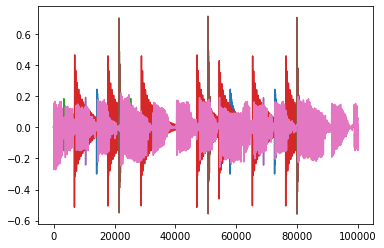

In [ ]:


plt.plot(ma[:,1000000:1100000].T)
#plt.ylabel('some numbers')
plt.show()

In [ ]:
g=0

gg=np.zeros(by.shape)

for i in range(len(by)):
  g=max((by[i],g*0.98))
  gg[i]=g

In [ ]:
plt.plot(np.array([by,tt]).T)
#plt.ylabel('some numbers')
plt.show()

NameError: ignored